In [6]:
import pandas as pd
import joblib
import os

# Load the clean test dataset
test_df = pd.read_csv("../data/processed/test_dataset.csv")

X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label']

# Load only the trained models from the /models directory
models_dir = "../models/"
models = {}
for filename in os.listdir(models_dir):
    # This check now ensures we only load model files and ignore the imputer/scaler
    if filename.endswith(".pkl") and "imputer" not in filename and "scaler" not in filename:
        model_name = filename.replace('.pkl', '').replace('_', ' ').title()
        models[model_name] = joblib.load(os.path.join(models_dir, filename))

print(f"Loaded {len(models)} models for evaluation.")

Loaded 6 models for evaluation.


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}
for name, model in models.items():
    # The model (or pipeline) will automatically handle scaling/imputation if needed
    y_pred = model.predict(X_test)
    
    # Store the performance metrics in a dictionary
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score", ascending=False)

print("Model Performance on Test Data:")
print(results_df)

Model Performance on Test Data:
                     Accuracy  Precision    Recall  F1-Score
Random Forest        0.986990   0.954345  0.980832  0.967407
Xgboost              0.986369   0.953783  0.978156  0.965815
Lightgbm             0.985406   0.951384  0.975721  0.963399
Mlp Classifier       0.956643   0.921099  0.852802  0.885636
Logistic Regression  0.924576   0.841441  0.760080  0.798694
Linear Svm           0.919240   0.833005  0.737616  0.782414


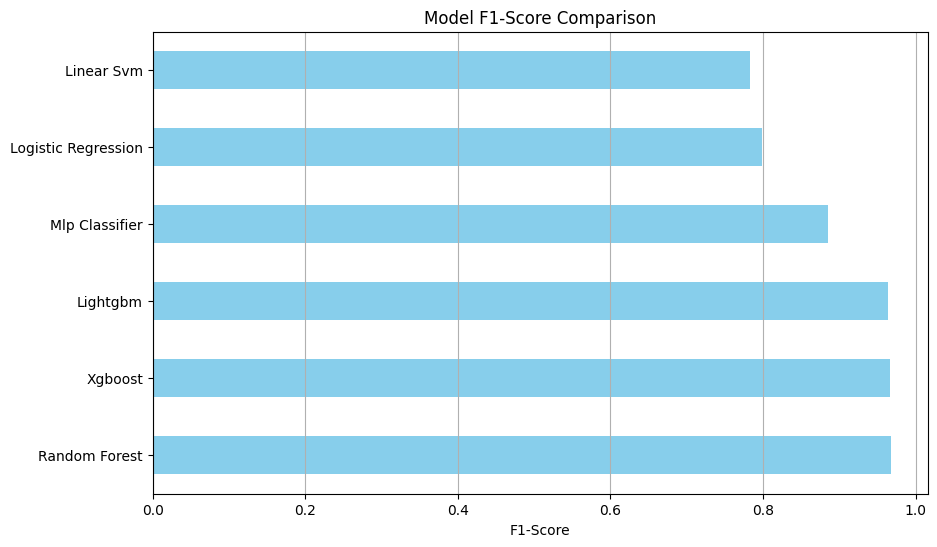

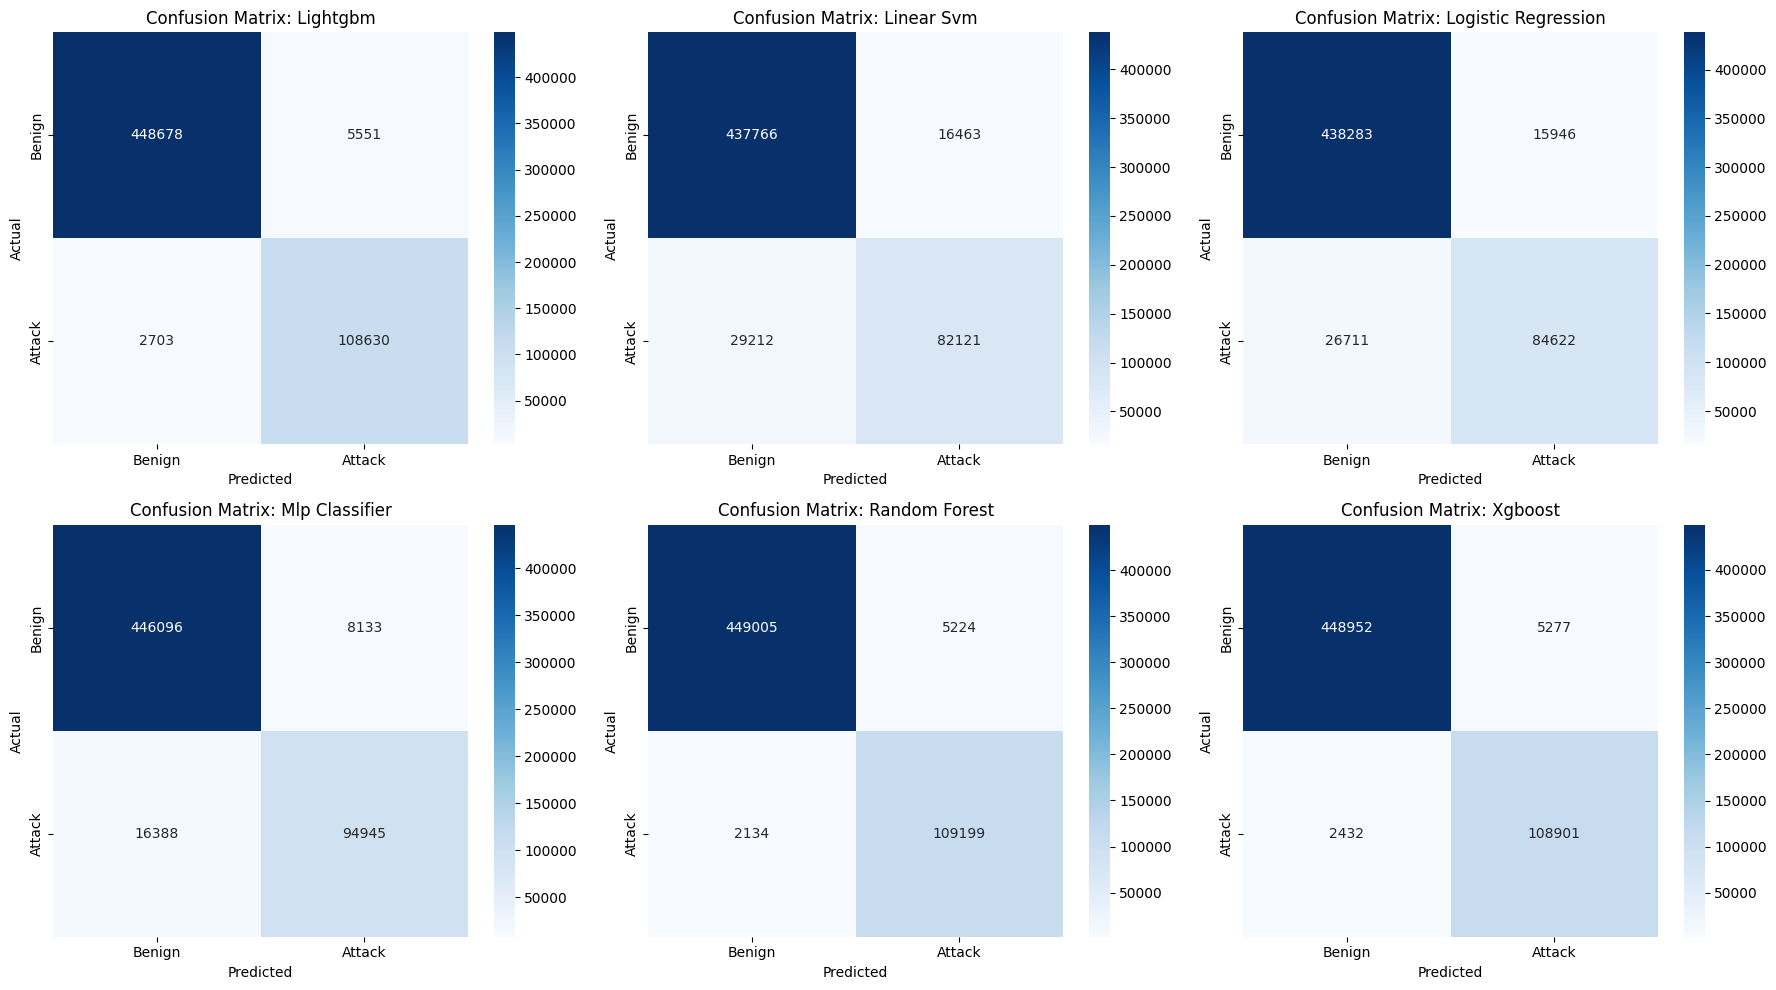

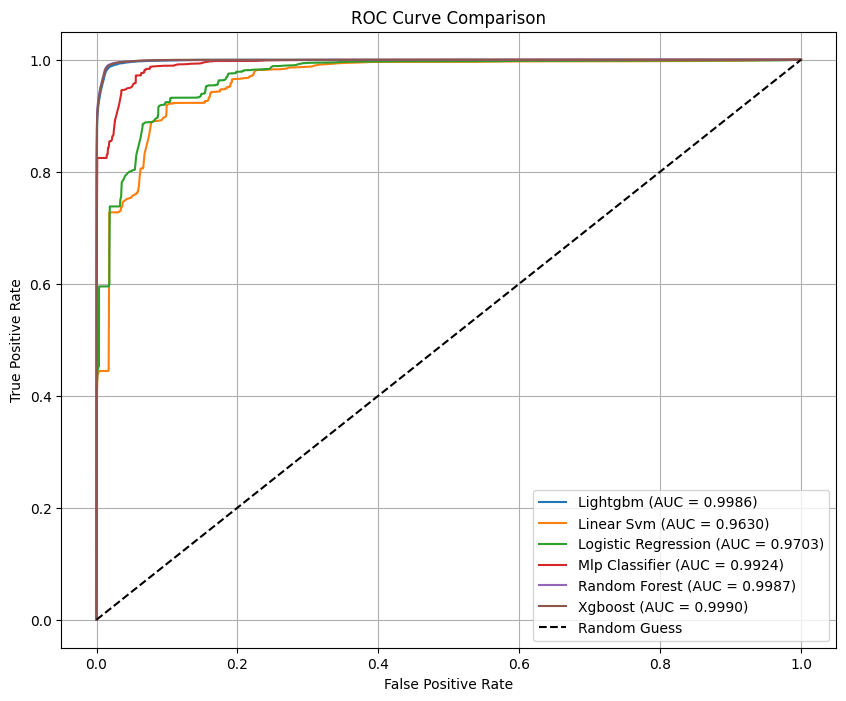

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# --- Bar Chart of F1-Scores ---
plt.figure(figsize=(10, 6))
results_df['F1-Score'].plot(kind='barh', color='skyblue')
plt.title('Model F1-Score Comparison')
plt.xlabel('F1-Score')
plt.grid(axis='x')
plt.show()


# --- Confusion Matrices ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide any unused subplots if you have fewer than 6 models
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# --- ROC Curve Comparison ---
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Use predict_proba for ROC, but handle models like SVM which use decision_function
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()